Let's start out by importing all the libraries we're going to use.

We need numpy to transform our input data into arrays our network can use, and we'll obviously be using several functions from Keras.

We'll also need to use some functions from the Natural Language Toolkit (NLTK) to preprocess our text and get it ready to train on. Finally, we'll need the sys library to handle the printing of our text.

In [5]:
import numpy as np
import requests
import sys
import nltk
import keras
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.layers import *
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping

#extra imports for my example
!pip install yfinance yahoofinancials
from yahoofinancials import YahooFinancials
import yfinance
import matplotlib.pyplot as plt
import math
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


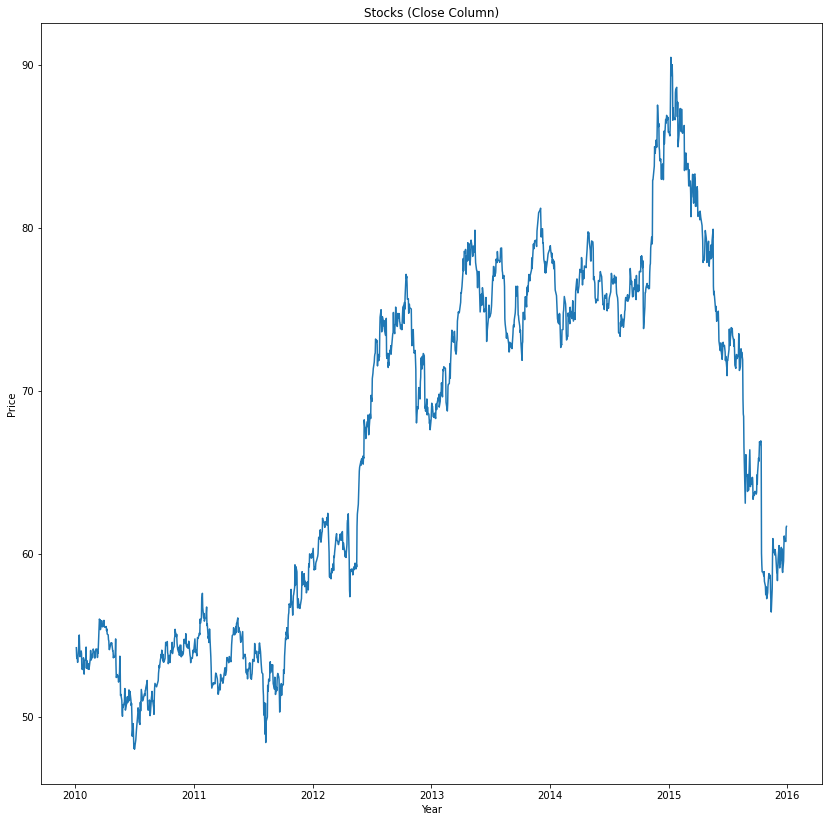

In [8]:
#Train the data for years 2010 - 2015
yfdata = yfinance.download('WMT',
                      start='2010-1-1',
                      end='2015-12-31', 
                      progress=False)

plt.figure(figsize=(14,14))
plt.plot(yfdata['Close'])

plt.title('Stocks (Close Column)')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

In [12]:
# Working with the raw data and working it into a dataframe accordingly
yfdata['Date'] = yfdata.index

yf_df = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])

yf_df['Date'] = yfdata['Date']
yf_df['Open'] = yfdata['Open']
yf_df['High'] = yfdata['High']
yf_df['Low'] = yfdata['Low']
yf_df['Close'] = yfdata['Close']

yf_df.shape

(1509, 5)

In [21]:
# Scaling the data appropriately
set_train = yf_df.iloc[:, 1:2].values

minmaxsc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = minmaxsc.fit_transform(set_train)

# X & Y train arrays - create and fill through iteration
X_train = []
y_train = []
for i in range(50, 1509):
    X_train.append(training_set_scaled[i-50:i, 0])
    y_train.append(training_set_scaled[i, 0]) 

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_train.shape
#(1459, 50, 1)

(1459, 50, 1)

In [22]:
#LSTM Modeling
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

In [23]:
#fitting the model (25 Epochs)
model.compile(optimizer = 'sgd', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 25, batch_size = 16)

Epoch 1/25
92/92 [==============================] - 8s 12ms/step - loss: 0.0902
Epoch 2/25
92/92 [==============================] - 1s 11ms/step - loss: 0.0270
Epoch 3/25
92/92 [==============================] - 1s 11ms/step - loss: 0.0085
Epoch 4/25
92/92 [==============================] - 1s 11ms/step - loss: 0.0070
Epoch 5/25
92/92 [==============================] - 1s 11ms/step - loss: 0.0058
Epoch 6/25
92/92 [==============================] - 1s 11ms/step - loss: 0.0058
Epoch 7/25
92/92 [==============================] - 1s 11ms/step - loss: 0.0057
Epoch 8/25
92/92 [==============================] - 1s 11ms/step - loss: 0.0052
Epoch 9/25
92/92 [==============================] - 1s 11ms/step - loss: 0.0047
Epoch 10/25
92/92 [==============================] - 1s 11ms/step - loss: 0.0054
Epoch 11/25
92/92 [==============================] - 1s 11ms/step - loss: 0.0059
Epoch 12/25
92/92 [==============================] - 1s 11ms/step - loss: 0.0051
Epoch 13/25
92/92 [==================

In [25]:
# Get new data for the next year
test_yf = yfinance.download('TSLA',
                      start='2016-1-1',
                      end='2016-12-31', 
                      progress=False)

In [26]:
# Same process to put the data into a dataset appropriately
test_yf['Date'] = test_yf.index

yf_test_data = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])

yf_test_data['Date'] = test_yf['Date']
yf_test_data['Open'] = test_yf['Open']
yf_test_data['High'] = test_yf['High']
yf_test_data['Low'] = test_yf['Low']
yf_test_data['Close'] = test_yf['Close']

In [30]:
# Getting the actual data to compare and then setting up / preprocessing the data for prediction
data_real = yf_test_data.iloc[:, 4:5].values

data_all = pd.concat((yf_df['Open'], yf_test_data['Open']), axis = 0)
inputs = data_all[len(data_all) - len(yf_test_data) - 60:].values
inputs = sc.transform(inputs.reshape(-1,1))
X_test = []
for i in range(50, 300):
    X_test.append(inputs[i-50:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

X_test.shape

(250, 50, 1)

No handles with labels found to put in legend.


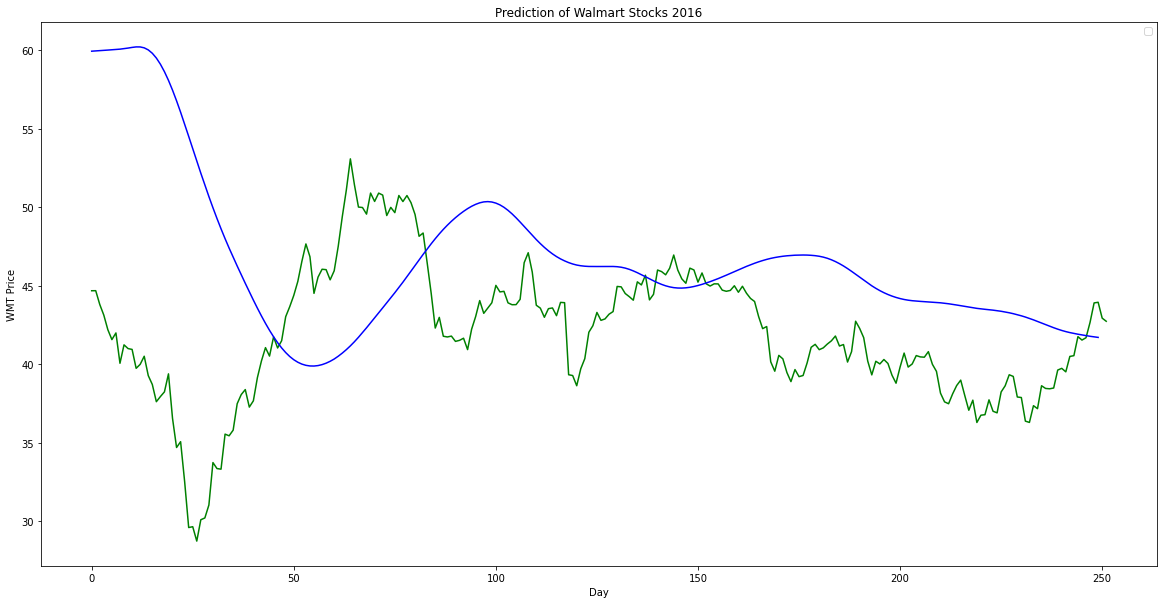

In [35]:
# Forming the prediction
pred = model.predict(X_test)
pred = sc.inverse_transform(pred)

#Plotting both lines
plt.figure(figsize=(20,10))
plt.plot(data_real, color = 'green')
plt.plot(pred, color = 'blue')
plt.title('Prediction of Walmart Stocks 2016')
plt.xlabel('Day')
plt.ylabel('WMT Price')
plt.legend()
plt.show()